In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import linear_model, manifold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
import scipy.sparse 

## Getting to know the data set

In [2]:
pd.read_csv('Truck-Crash-Data/origPositions.csv')

,NodeNumber,xPos,yPos,zPos
0,2023483,4092.1599,323.10001,487.19998
1,2023484,4079.5200,324.01999,493.63998
2,2023485,4066.8899,324.95999,500.07999
3,2023486,4054.2600,325.89999,506.51999
4,2023487,4041.6299,326.85999,512.95996
...,...,...,...,...
3228,2028447,3497.6399,-402.69998,399.26999
3229,2028448,3491.9600,-427.53998,396.35999
3230,2028449,3502.1399,-423.73999,400.56000
3231,2028450,3474.6899,-407.62000,391.42999


We can ignore the node numbers, they're always in order

In [3]:
origPositions = np.array(pd.read_csv('Truck-Crash-Data/origPositions.csv'))[:,1:]
nPoints = origPositions.shape[0]
nDisp = 126
displacementSim = np.zeros((nDisp, nPoints, 3))
for i in range(nDisp):
    displacementSim[i] = np.array(pd.read_csv('Truck-Crash-Data/DisplacementSimulation' + str(i+1) + '.csv'))[:,1:]
displacementSim.shape

(126, 3233, 3)

Visualize the beams before and after the simulated crash:

In [4]:
# rescale for easier plotting 
originalMax = np.max(origPositions, axis = 0)
originalMin = np.min(origPositions, axis = 0)
displacedMax = np.max(displacementSim + origPositions, axis = (0, 1))
displacedMin = np.min(displacementSim + origPositions, axis = (0, 1))
maximum = np.maximum(originalMax, displacedMax)
minimum = np.minimum(originalMin, displacedMin)

origPositionsNorm = (origPositions - minimum)/(maximum - minimum)
displacedPositionsNorm = ((displacementSim + origPositions) - minimum)/(maximum - minimum) 

In [5]:
def beamPlot(nodes, elevation = 30, rotation = 60, which = "both", title = ""):
    """ nodes:      array containing the x, y, z positions of the nodes
        elevation:  elevation angle in the vertical plane in degrees
        rotation:   angle in the horizontal plane in degrees
        which:      one of {"left", "right", "both"}, controls which beams are shown
        title:      string for figure title
    """
    maxLimits = [1, 1, 1]
    minLimits = [0, 0, 0]
    margin = 0.05
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(projection = "3d")
    if which == "both":
        ax.scatter(nodes[1714:,0], nodes[1714:, 1], nodes[1714:, 2], s = 5,color = "#488f31", alpha = 0.5) 
        ax.scatter(nodes[:1714,0], nodes[:1714, 1], nodes[:1714, 2], s = 5,color = "#de425b", alpha = 0.5) # we have more nodes in the red beam
    elif which == "right" :
        ax.scatter(nodes[:1714,0], nodes[:1714, 1], nodes[:1714, 2], s = 5, color = "#de425b", alpha = 0.5) 
    elif which == "left":
        ax.scatter(nodes[1714:,0], nodes[1714:, 1], nodes[1714:, 2], s = 5,color = "#488f31", alpha = 0.5)
    ax.tick_params(color = "grey")
    ax.view_init(elev = elevation,azim = rotation)
    ax.set_xlim(min(minLimits[0], 0) - margin, max(maxLimits[0], 1) + margin)
    ax.set_ylim(min(minLimits[1], 0) - margin, max(maxLimits[1], 1) + margin)
    ax.set_zlim(min(minLimits[2], 0) - margin, max(maxLimits[2], 1) + margin)
    plt.title(title, size = 20, y = 0.95, loc="left")
    plt.show()


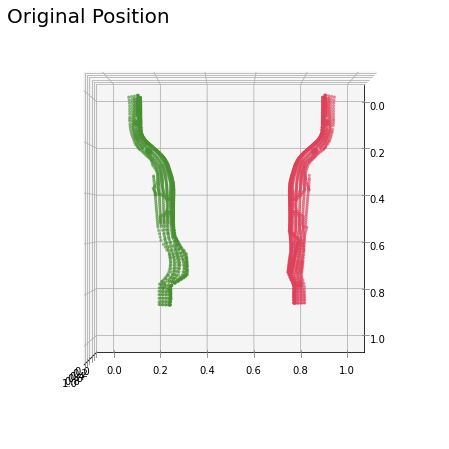

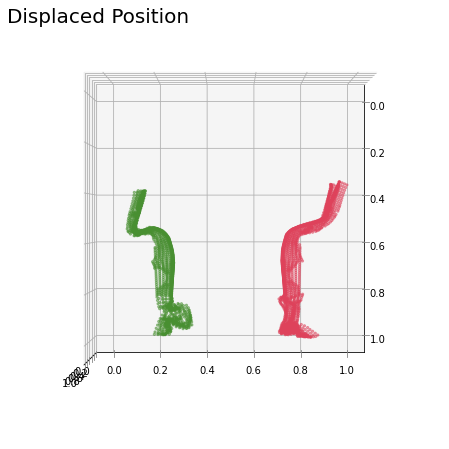

In [6]:
beamPlot(origPositionsNorm[:,:], 90, 0, "both", title = "Original Position")
beamPlot(displacedPositionsNorm[44,:,:], 90, 0, "both", title ="Displaced Position")

Next we want to visualize the displacement:

This is done by first normalizing appropriately and then mapping the displacement in a certain direction to a range of colors. 
We then create a sort of barcode by plotting a thin strip of color for each node. The order of the nodes is fixed so the resulting image gives an idea of the overall displacement. 
The goal is to have a more abstract but also more accurate way of visualizing a data point.

In [7]:
def normalize_sign(matrix):
    max = np.max(matrix, axis = (0, 1))
    min = np.min(matrix, axis = (0, 1))
    limits = np.maximum(np.abs(max), np.abs(min)) 

    return displacementSim/limits # sign is preserved, normalize with respect to the largest displacement in any direction
displacementNorm = normalize_sign(displacementSim)

In [8]:
def displacementPlot(data, showDirection = "one", title = ""):
    """ data:           normalized displacement data, if direction != "one", then of shape (N, 3), else of shape (N, )
        showDirection:  string, controls which directions are shown
        title:          string for figure title
    """
    norm = mcolors.CenteredNorm(vcenter = 0, halfrange = 1) # assume normalization
    mapper = cm.ScalarMappable(norm = norm, cmap = cm.RdYlBu)
    directions = ["X", "Y", "Z"]

    if showDirection == "xyz":
        fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(21,3))
        for i in [0, 1, 2]:
            rgbaArray = np.expand_dims(mapper.to_rgba(data[:, i]), axis = 0)
            ax[i].axis("off")
            ax[i].set_title(directions[i] + "-direction")
            ax[i].imshow(rgbaArray, extent=[0, rgbaArray.shape[1], 0, 1], aspect= "auto")
            fig.tight_layout()
            fig.suptitle(title, size = 20, y = 1)
        plt.show()

    if showDirection == "yz":
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(21,3))
        for i in [0, 1]:
            rgbaArray = np.expand_dims(mapper.to_rgba(data[:, i+1]), axis = 0)
            ax[i].axis("off")
            ax[i].set_title(directions[i+1] + "-direction")
            ax[i].imshow(rgbaArray, extent=[0, rgbaArray.shape[1], 0, 1], aspect= "auto")
            fig.tight_layout()
            fig.suptitle(title, size = 20, y = 1)
        plt.show()
            
    if showDirection == "one":
        fig = plt.figure(figsize=(8, 2))
        rgbaArray = np.expand_dims(mapper.to_rgba(data), axis = 0)
        plt.axis("off")
        plt.imshow(rgbaArray, extent=[0, rgbaArray.shape[1], 0, 1], aspect= "auto")
        plt.title(title, size = 20, y = 1, loc = "left")
        plt.show()
    

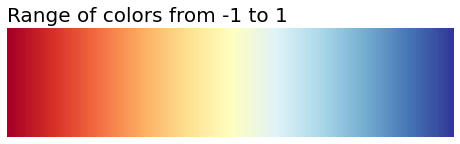

In [9]:
test = np.arange(start = -1, stop = 1, step = 0.01)
displacementPlot(test, title = "Range of colors from -1 to 1")

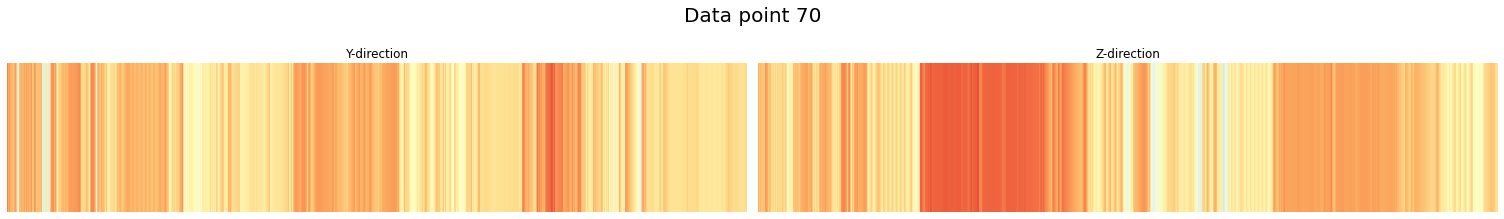

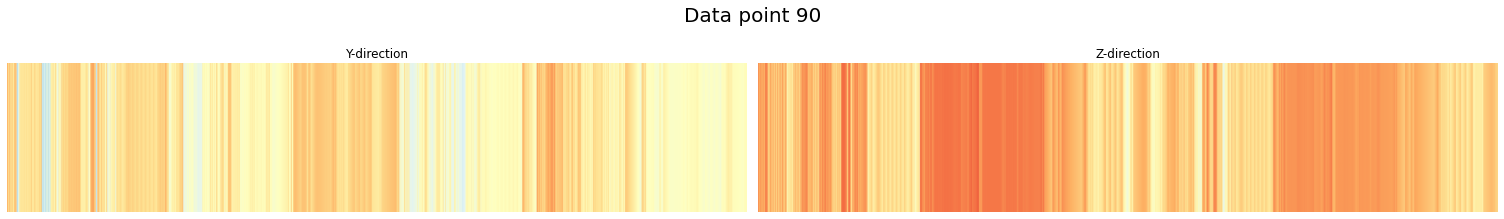

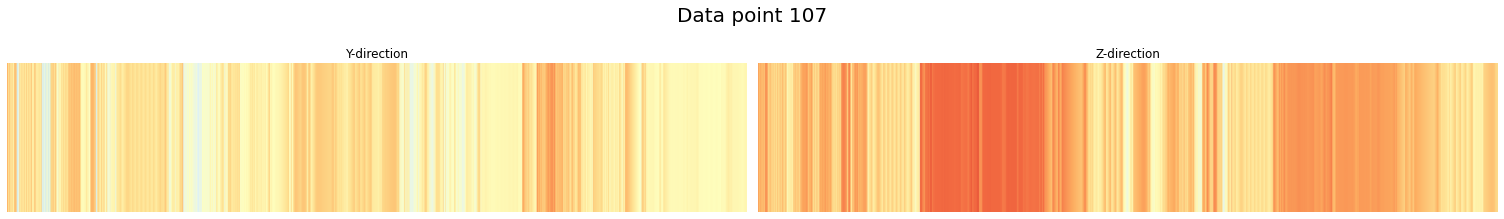

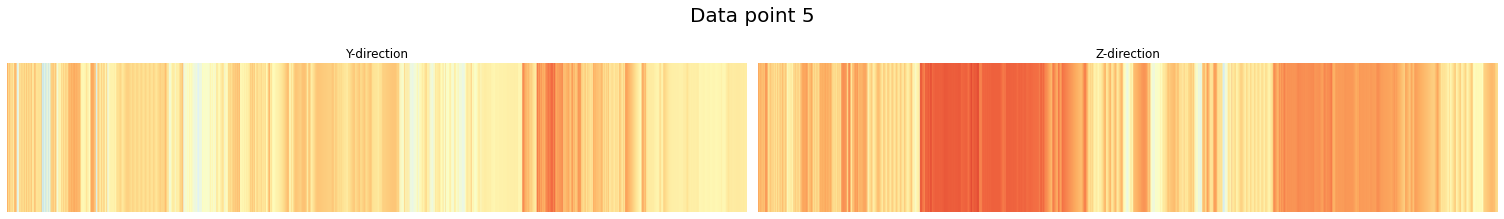

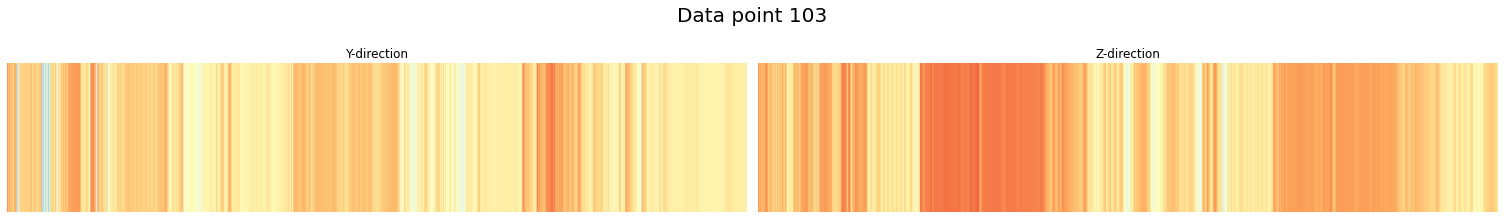

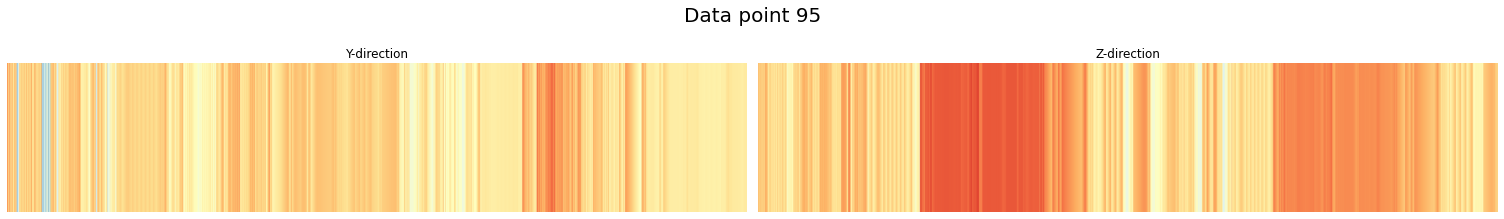

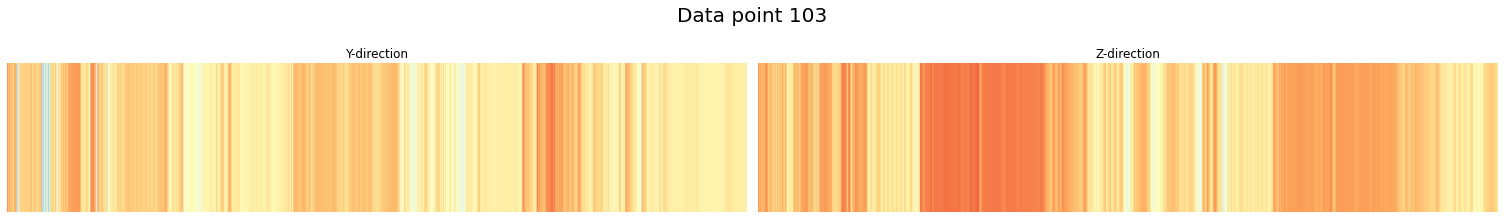

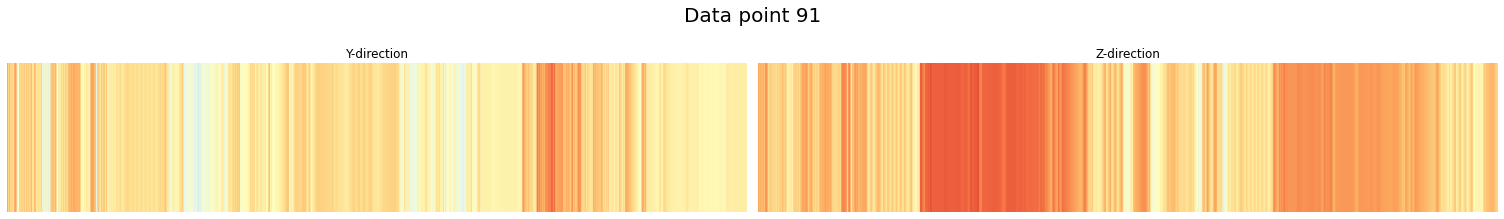

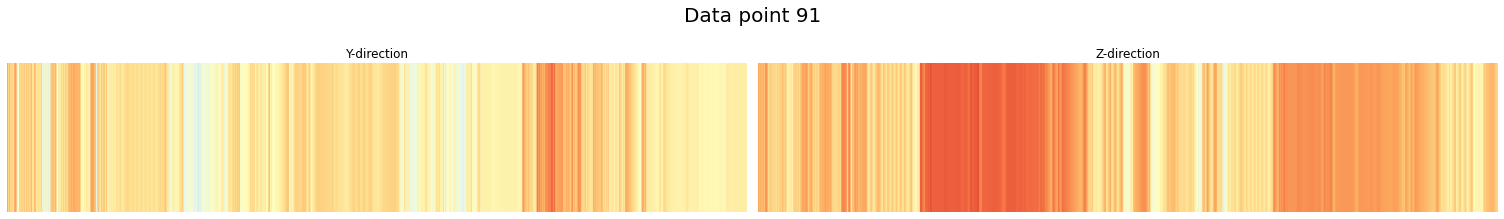

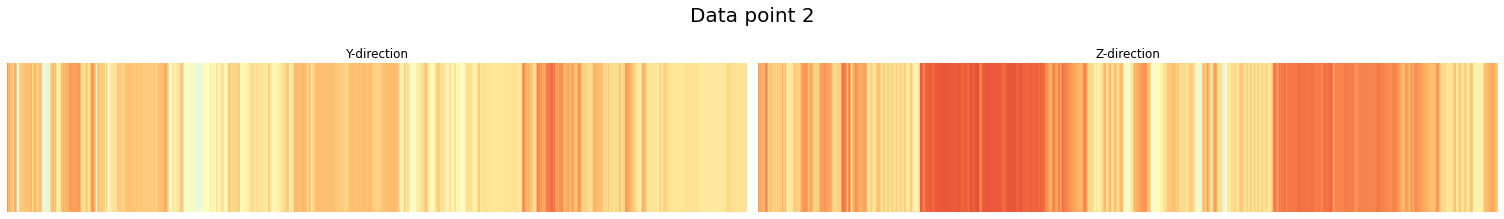

In [10]:
%matplotlib inline
for i in np.random.choice(nDisp, 10):
    displacementPlot(displacementNorm[i, :, :], showDirection= "yz", title = "Data point " + str(i))

From these plots we can already expect that there are at least two groups apparent in this data set.

### Naive PCA Approaches

First approach: do PCA taking all displacements as separate points. This allows us to use the plot above to look at the eigendisplacements.

In [11]:
dispVector = displacementNorm.reshape((nDisp, nPoints*3))
pca = PCA(n_components=50)
pca = pca.fit(dispVector)
Vq = pca.components_.reshape((50, nPoints, 3))

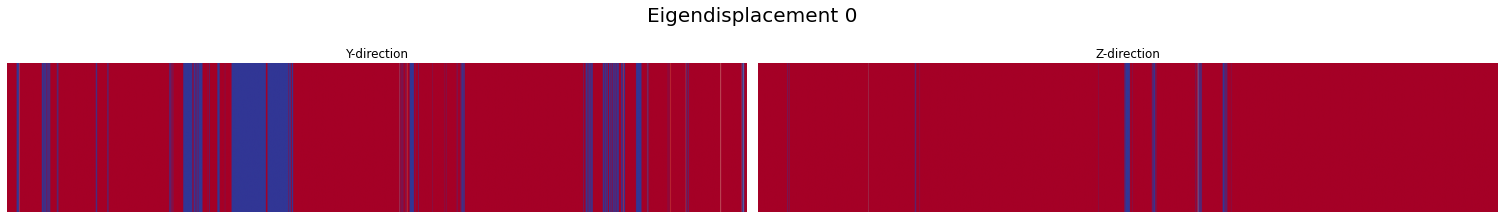

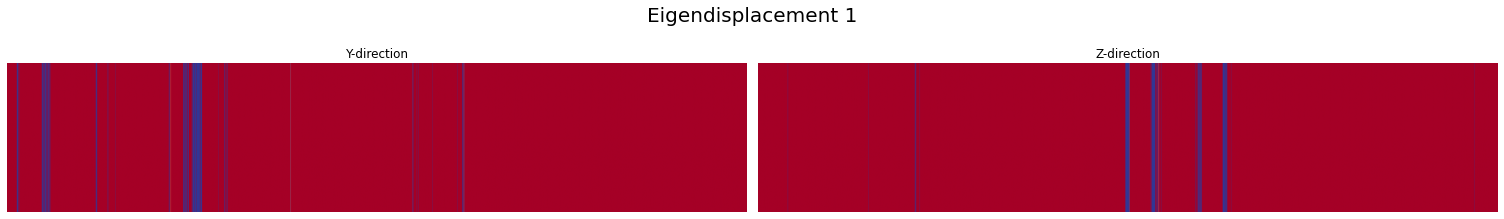

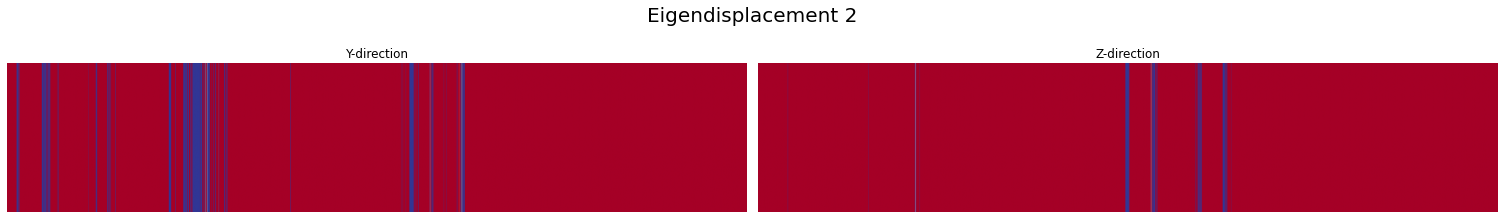

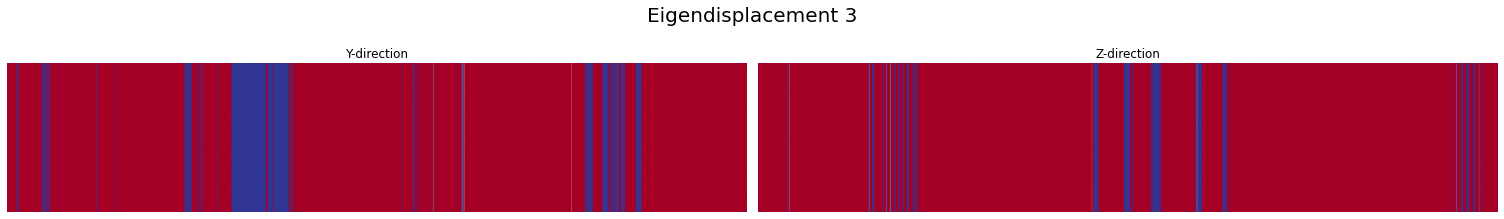

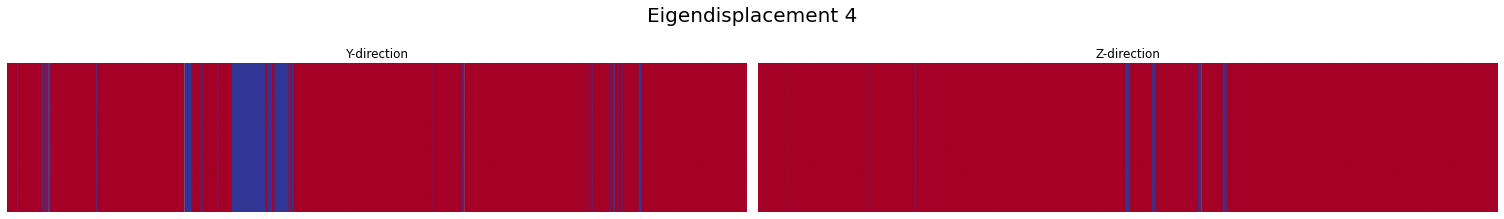

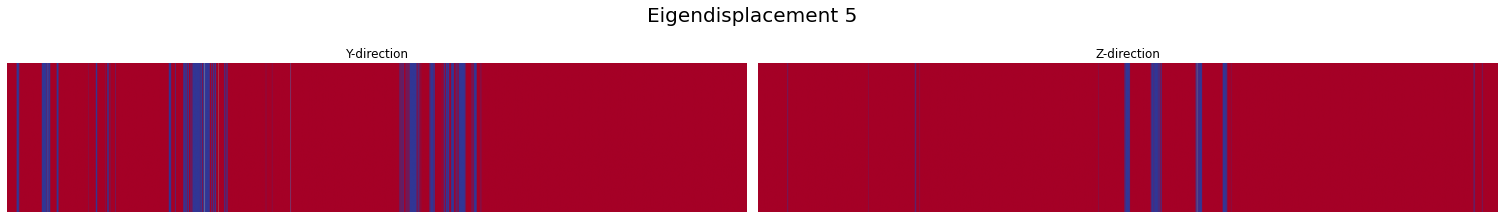

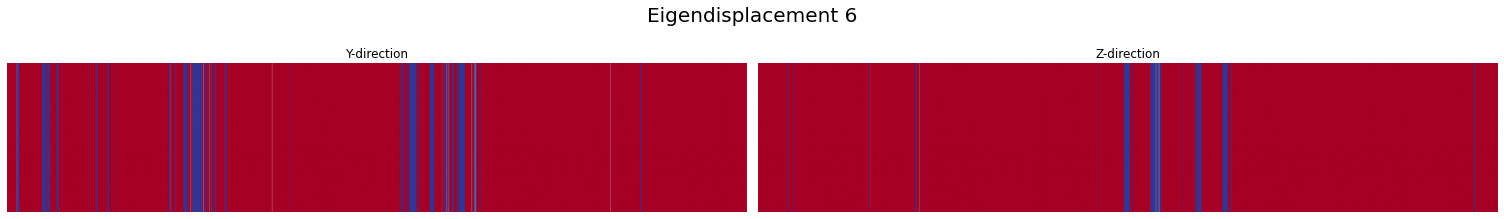

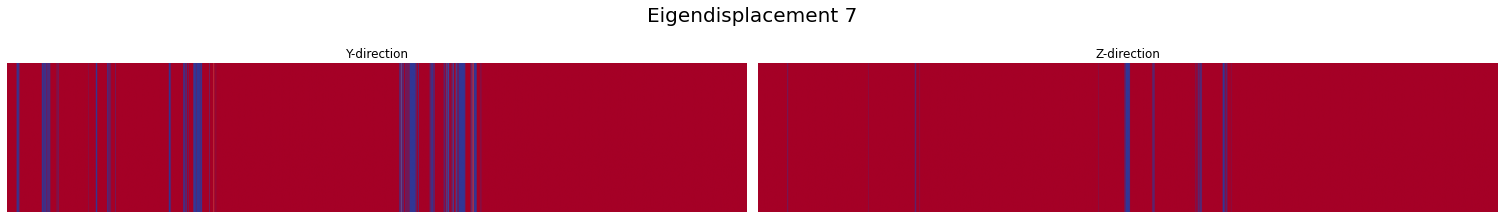

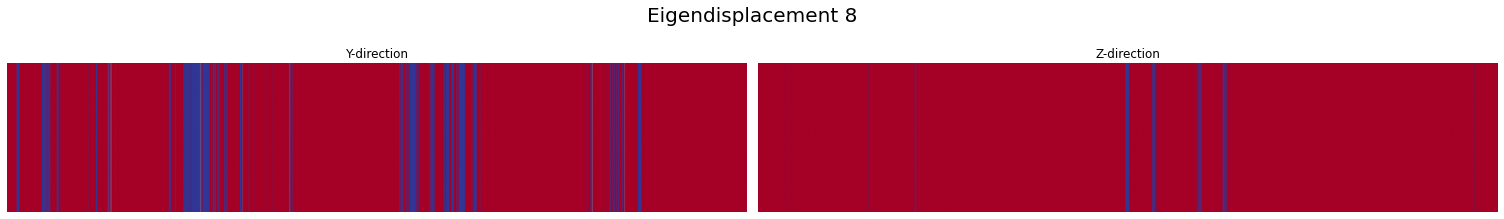

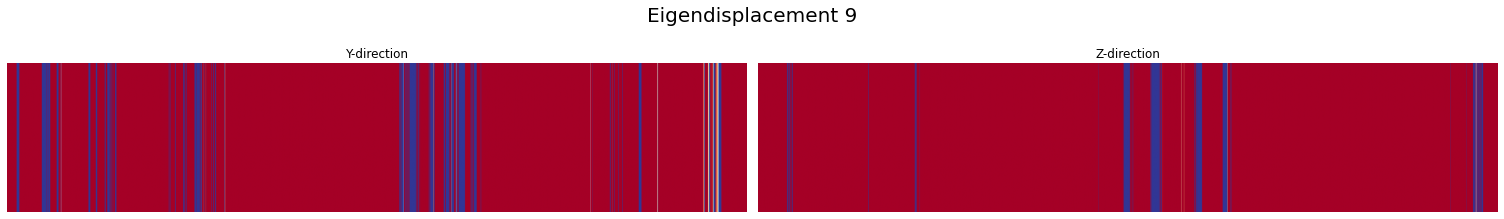

In [12]:
%matplotlib inline
VqNorm = normalize_sign(Vq)
for i in range(10):
    displacementPlot(VqNorm[i, :, :], showDirection= "yz", title = "Eigendisplacement " + str(i))

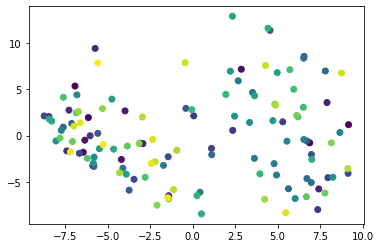

In [13]:
pca = PCA(n_components=2)
pca = pca.fit(dispVector)

reducedDisp = pca.transform(dispVector)
plt.scatter(reducedDisp[:,0],reducedDisp[:,1], c=range(nDisp))

**Second approach** Very similar but classifying points, not simulations.

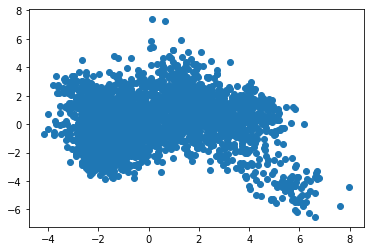

In [14]:
dispVector = displacementNorm.reshape((nPoints, nDisp*3))
pca = PCA(n_components=2)
pca = pca.fit(dispVector)

reducedDisp = pca.transform(dispVector)
plt.scatter(reducedDisp[:,0],reducedDisp[:,1])

This doesn't show any clear differences between the points.

We can also add the displacement to the position to observe the final position, and do these approaches on that data

In [15]:
posVector = displacedPositionsNorm.reshape((nDisp, nPoints*3))
pca = PCA(n_components=2)
pca = pca.fit(posVector)
Vq = pca.components_.reshape((2, nPoints, 3))

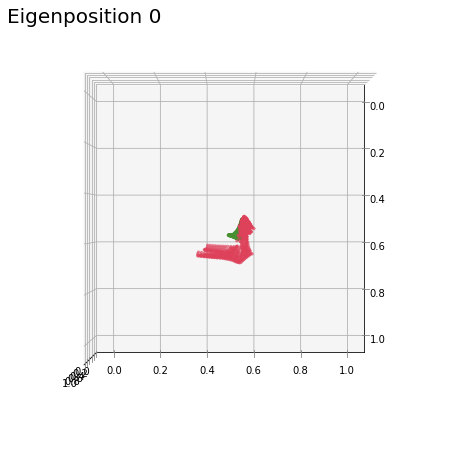

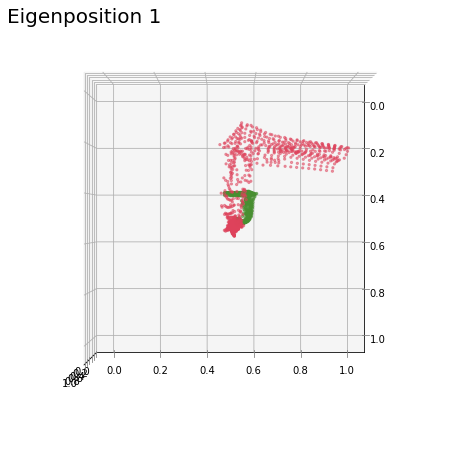

In [16]:
%matplotlib inline
VqNorm = (Vq - np.min(Vq))/np.ptp(Vq)
for i in range(2):
    beamPlot(VqNorm[i,:,:], 90, 0, "both", title ="Eigenposition " + str(i))

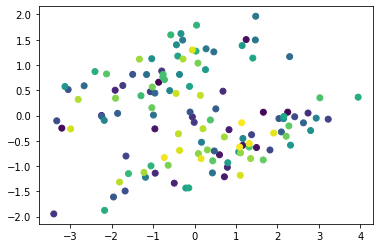

In [17]:
reducedPos = pca.transform(posVector)
plt.scatter(reducedPos[:,0],reducedPos[:,1], c=range(nDisp))

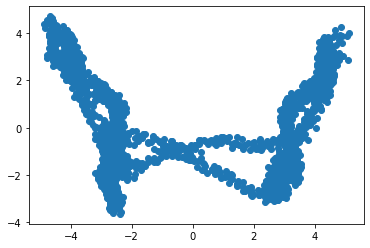

In [18]:
posVector = displacedPositionsNorm.reshape((nPoints, nDisp*3))
pca = PCA(n_components=2)
pca = pca.fit(posVector)

reducedPos = pca.transform(posVector)
plt.scatter(reducedPos[:,0],reducedPos[:,1])

Here you can see it sort of conserves the figure of the displaced beams.

## Clustering the nodes using K-means and the L-method

In [19]:
# build data matrix of the euclidean norms of the displacements
N = displacementSim.shape[0]
X = np.linalg.norm(displacementSim, axis = 2).T # each node corresponds to a row
X.shape

(3233, 126)

In this section we apply K-means to cluster the nodes according to the norms of their displacements in each simulation as proposed in [1].
<br>We determine the number of clusters using the L-method described in [2], though we don't use hierarchical clustering. <br>

A brief description of the method is given in the following. <br>

First a suitable _evaluation graph_ which shows the values given by an evaluation function of the number of clusters $\{2, 3, ..., maxK\}$ is constructed. In our case the evaluation function is the sum of squared distances of samples to their closest cluster center. The evaluation graph usually shows a kind of an L-shape with a sharp decrease to the left and a much flatter area to the right, the area connection the two is called the "knee" of the graph and most likely contains reasonable choices for the cluster size. 

We find the knee by iterating through all possible options $c = 3, ..., maxK - 2$ and approximating the values of the points to the left and right of $c$, $L_c = 2, ... , c$ and $R_c = c+1, ..., maxK$, linearly and looking at their respective RMSE (the root of the MSE) $RMSE(L_c)$ and $RMSE(R_c)$. We choose the values of $c$ which minimizes the weighted error $$\frac{c-1}{maxK-1}RMSE(L_c) + \frac{maxK - c}{maxK-1} RMSE(R_c).$$ The weights correspond to the portion of points in $L_c$ and $R_c$.

In [20]:
# get evaluation graph data
maxK = 10
inertiaData = np.zeros(maxK - 1)
for k in np.arange(maxK - 1): # starting at two
    kmeans = KMeans(n_clusters= k + 2, n_init = 10, tol=1e-5).fit(X)
    inertiaData[k] = kmeans.inertia_


# choose linear approximations of the left and right side of the evaluation graph
def rmse(data, c, b):
    xAxis = np.arange(b - 1) + 2
    regrL = linear_model.LinearRegression()
    regrR = linear_model.LinearRegression()
    regrL.fit(xAxis[:c, np.newaxis], data[:c].reshape((c, 1)))
    regrR.fit(xAxis[c:, np.newaxis], data[c:].reshape((b-1-c, 1)))
    rmseL = np.sqrt(mean_squared_error(data[:c], regrL.predict(xAxis[:c].reshape((c, 1)))))
    rmseR = np.sqrt(mean_squared_error(data[c:], regrR.predict(xAxis[c:].reshape((b-1-c, 1)))))
    return (c-1)/(b-1) * rmseL + (b-c)/(b-1) * rmseR

rmseData = np.zeros(maxK-4)
for c in np.arange(start = 2, stop = maxK - 2):
    rmseData[c-2] = rmse(inertiaData, c, maxK)

cMin = np.argmin(rmseData) + 2

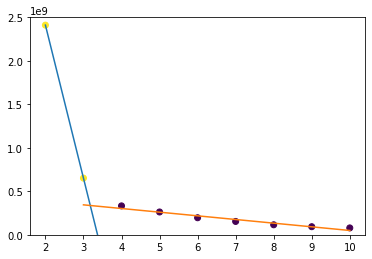

In [21]:
# show evaluation graph and approximate its knee (the point of maximum curvature)
xAxis = np.arange(maxK - 1) + 2
regrL = linear_model.LinearRegression()
regrR = linear_model.LinearRegression()
regrL.fit(xAxis[:cMin, np.newaxis], inertiaData[:cMin].reshape((cMin, 1)))
regrR.fit(xAxis[cMin:, np.newaxis], inertiaData[cMin:].reshape((maxK-1-cMin, 1)))

plt.scatter(xAxis, inertiaData, c = xAxis <= cMin +1  )
plt.plot(xAxis[:cMin + 1], regrL.coef_[0] * xAxis[:cMin + 1] + regrL.intercept_)
plt.plot(xAxis[cMin - 1:], regrR.coef_[0] * xAxis[cMin - 1:] + regrR.intercept_)
plt.ylim(0, 2.5*1e9)
plt.show()

Of course, in our case the knee could also have been determined by just looking at the graph. But automating this process would of course be a necessary step in a fully-automated analysis. Also, the L-method becomes a lot more useful when there are more points to the left of the knee (see examples shown in [2]). <br>
Based on results above we choose k = 3 .

In [22]:
k = 3
kmeansNodes = KMeans(n_clusters= k, n_init = 15, tol=1e-5).fit(X) # we upped n_init and lowered the tolerance since accuracy is important in this state

In [23]:
def beamPlotClustered(nodes,labels, elevation = 30, rotation = 60, title = ""):
    maxLimits = [1, 1, 1]
    minLimits = [0, 0, 0]
    margin = 0.05
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(projection = "3d")
    scatter = ax.scatter(nodes[:,0], nodes[:, 1], nodes[:, 2], s = 5, c= labels, cmap = "Set1", alpha = 0.5)   
    ax.tick_params(color = "grey")
    ax.view_init(elev = elevation,azim = rotation)
    ax.set_xlim(min(minLimits[0], 0) - margin, max(maxLimits[0], 1) + margin)
    ax.set_ylim(min(minLimits[1], 0) - margin, max(maxLimits[1], 1) + margin)
    ax.set_zlim(min(minLimits[2], 0) - margin, max(maxLimits[2], 1) + margin)
    plt.title(title, size = 20, y = 1, loc="left")
    legend = ax.legend(*scatter.legend_elements(), title="Clusters", loc = "best")
    ax.add_artist(legend)
    plt.show()

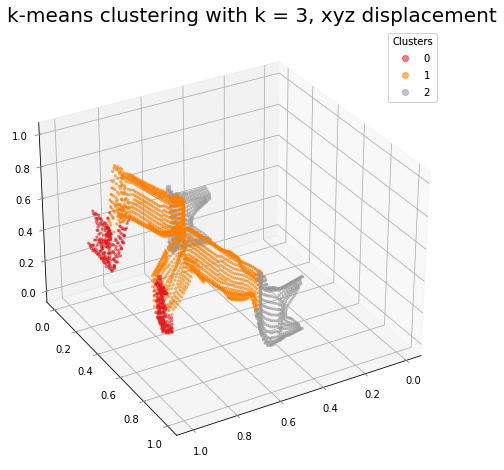

In [24]:
beamPlotClustered(displacedPositionsNorm[10, :, :], kmeansNodes.labels_, elevation=30, rotation=60, title="k-means clustering with k = " + str(k) + ", xyz displacement")

From looking at the plots we think that K-means is able to capture which parts of the beam behave similarily in the crash, though $k=4$ is also a good option. For our purposes this clustering is sufficient but for more complicated models it has been suggested in [1] that non-linear clustering methods like spectral clustering might be necessary. 

## Nonlinear Dimensionality Reduction based on <br> Locally Linear Tangent Space Estimation

This section is based on the sections 2.4.1 and 2.5 in [1] and then elaborates on the ideas mentioned there using [3] and [4].

The idea is to think of our data set $X$ of size $N$ as a sample of points from a low-dimensional, smooth $s$-submanifold $M$ of $\mathbb{R}^d$, $d$ being the dimension of our data points. It is reasonable to expect that this sampling contains some noise but for simplicity we neglect this point. We further assume that the manifold is represented by a function $$f: U \subset \mathbb{R}^s \rightarrow \mathbb{R}^d ,$$  where $U$ is a compact set with open interior. There are two possible tasks stemming from this understanding of the data set:

1. We can estimate low-dimensional vectors $\tau_i$ corresponding to our samples $x_i$, s.t. $f(\tau_i) \approx f(x_i)$. Since $f$ is likely nonlinear this would be an instance of *nonlinear dimensionality reduction* . Since we want to find structure in our data set this is our main goal. We call the $\tau_i$ global coordinates. 

2. We can try to reconstruct the mapping $f$ and therefore provide estimates of $f(\tau)$ for some $\tau \in U$ . This is callled *manifold learning*. <br> In our case this is probably not that advantageous on it's own, since it would be hard to recover the parameters of a car crash simulation generated in this way accurately enough to be useful. However, we will see that we can use an estimate of the manifold $f(C)$ to derive a way of solving 1 . <br> It is also interesting to consider a manifold estimate based on a training data set and then determine how well it fits to a test data set in order to get a sense of the accuracy. This is done with success in section 2.5 in [1] for the estimation described below and inspired to look into this in the first place. 

The LTSA-method works as follows.

For each sample $x \in M$ the nearest $k \geq s$ neighbors $X_i = (x_{i_1}, ... , x_{i_k}) \in \mathbb{R}^{k \times d}$ of $x$ are determined, ideally with respect to the shortest path in the same connected component of $M$, the geodesic distance. 

We then compute the best $s$-dimensional affine subspace approximation of $X_i$, as we know this is given by the affine subspace spanned by the $s$ principal components centered around the mean $\bar{x}^{(i)}$ of $X_i$ . Hence the name *locally linear* . We call the resulting $\theta^{(i)}_1 , ... , \theta^{(i)}_k$ the local coordinates and $Q_i$ the matrix with columns given by the $s$ largest left singular vectors of $X_i$. <br>
This part can also be understood as computing an estimation $\tilde{T}_{x_i} M$ of the tangent space $T_{x_i} M$ at $x_i$ but we won't go into detail on the justification. 

We estimate the underlying manifold by the projection of the Voronoi cells $V_{x_i} = \{y \in \mathbb{R}^d: ||y-x_i|| \leq ||y - x_j||, x_j \in X \}$ of our samples $x_i \in X$ onto the estimated tangent spaces. We can imagine glueing the affine subspaces together. 

The issue is that while we have local $s$-dimensional representations of our samples, they are all with respect to different affine subspaces, so we cannot as yet visualize them in $s$ dimensions. 
So besides choosing the global coordinates, we also look for choose suitable mappings $L_i$ from $\tilde{T}_{x_i} M$ to $\mathbb{R}^s$. <br>For simplicity we only consider affine $L_i$. 

The idea is to minimize the error terms $\epsilon^{(i)}_j$ in $$\tau_{i_j} = \bar{\tau}^{(i)} + L_i  \theta^{(i)}_j + \epsilon^{(i)}_j,$$ for $j = 1, ... , k$, $i = 1, ... , N$ and $\bar{\tau}^{(i)}$ denoting the mean of $\{\tau^{(i)}_1, ..., \tau^{(i)}_k \}$, the global coordinates of the points in $X_i$. This mimicks the local structure determined above since $Q_i$ and $\theta^{(i)}_j$, minimize the error $\xi^{(i)}_j$ in $$x_{i_j} = \bar{x}^{(i)}  + Q_i \theta^{(i)}_j + \xi^{(i)}_j.$$

The derivation of the in this sense optimal global coordinates $T = (\tau_{1}, ..., \tau_{N})$ can be found in [3], section 4 (and more computational details in section 7), but in the end in comes down to another computation of eigenvectors. Intuitively, we can expect that points on the manifold which lie close together in an area of low curvature are going to be projected down in a very similar fashion. We can hope to differentiate groups which fit those criteria by using this method.

It is apparent that the choices of $s$, $k$ and the way the nearest neighbors are determined are very important. 

We won't go into estimating the instrinsic dimension $s$ and only consider $s = 1$ or $s = 2$ since this is the most useful for visualisation. 

In the examples shown in [3] $k$ is usually set to a value around 10. We try a few different $k$ values, since it says in [3] that "In general, k should be chosen to match the sampling density, noise level and the curvature at each data points so as to extract an accurate local tangent space." and the points mentioned are all unknown in this case. 

There is an sklearn implementation of this algorithm we can use for our analysis though it uses different methods than [1] to determine the $k$ nearest neighbors. The default sklearn version computes the nearest neighbors with respect to the euclidean 2-norm either by computing all the distances or by tree-based approaches. After comparing the complexities of the different algorithms we decided to use the brute force approach for our tests, since our number of data points is pretty small.

On the other hand, the authors of [1] use the shortest path distances computed by Dijsktra's algorithm on the adaptive neighborhood graph described in [3] to approximate the geodesic distances between the samples. 
We will implement this $k$ nearest neighbor search and compare it. We also briefly explore their idea of analysing the clusters of the nodes obtained in the last section separately. 

### Adaptive Neighborhood Graph

For $c > 1$ the $c$-neighborhood of a sample $x \in X$ is defined as $$N_c(x) = \{ y \in X, y \neq x : ||x - y|| \leq c ||x - y' || \text{ for all } y' \in X, y' \neq x\}.$$ The adaptive neighborhood graph consists of the vertices $X$ and the undirected edges $\{(x, y) : x \in N_c(y) \text{ or } y \in N_c(x)\}$.

In particular $N_c(x)$ includes the point closest to $x$ . The larger $c$ the more other points close to $x$ are included as well. 
In [3] a number of properties of this graph are presented but they depend on c being chosen depending on the quality of the sampling which, in our case, is unknown and [1] doesn't mention which one they used, so we will try a few different values for $c$. <br>
 The estimated geodesic distance between $x, y \in X$ is given by the minmum of $$\sum^m_{i = 1} || x_i - x_{i-1} || $$ over all paths $x_0 = x, x_1, ... , x_m = y$ connecting $x$ and $y$ in $X$. The proofs of the statements on the approximation properties of the estimated geodesic distances given in section 5 of [3] are quite long and we won't repeat them here. It is helpful to keep in mind that [3] shows that the estimates provide better and better upper bounds as the samples get denser but that the authors were unable to prove the same for our estimates as a lower bound. In fact their result suggests that the estimate provides a better lower bound for larger $c$. This makes sense since the whole point of the graph structure is to enforce contraints on our movement through space in order to avoid "jumping" over empty space between different parts of the manifold. 

In [25]:
def cNeighborhood(i, distanceMatrix, c):
    neighborIndices = distanceMatrix[i, :] <= c * np.min(np.delete(distanceMatrix[i, :], i))
    neighborIndices[i] = False 
    return np.arange(distanceMatrix.shape[0])[neighborIndices]

def getGeodesicDistances(distanceMatrix, c):
    N = distanceMatrix.shape[0]
    neighborhoods = [cNeighborhood(i, distanceMatrix, c) for i in np.arange(N)]
    # build graph
    edges = np.zeros((N, N))
    for i in np.arange(N):
        for j in np.arange(start = i + 1, stop = N): # edges is a symmetrix matrix since the graph is undirected
            if np.any(neighborhoods[i] == j) or np.any(neighborhoods[j] == i):
                edges[i, j] = distanceMatrix[i, j]
    edges = edges + edges.T # diagonal is zero
    neighborhoodGraph = scipy.sparse.csr_matrix(edges)
    return scipy.sparse.csgraph.dijkstra(csgraph = neighborhoodGraph) # inf corresponds to not being in the same connected component

Even though getting the indicies in the getGeodesicDistance function is very inefficient this allows us to easily use our distance estimates in  the sklearn algorithm. Unfortunately sklearns LTSA function does not allow to set a custom metric directly, only their nearest neighbor constructor does so. In the file custom_LTSA.py we mostly copied their source code and set our custom metric.

In [26]:
# flatten the displacement, we do not center around the mean since this is done later in the algorithm for each X_i
displacementFlat = displacementSim.reshape((N, -1)) 
distanceMatrix = squareform(pdist(displacementFlat, 'euclidean'))
c = 1.2
geodesicDistances = getGeodesicDistances(distanceMatrix, c)

def geodesicDistance(x, y): # custom metric to use in the sklearn algorithm
    i = np.where(np.all(displacementFlat==x,axis=1))
    j = np.where(np.all(displacementFlat==y,axis=1))
    return geodesicDistances[i, j]

Let's quickly compare how much the estimated geodesic distances differ from the euclidean ones for different values of $c$:

In [27]:
for c in [1.1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
    geodesicDistances = getGeodesicDistances(distanceMatrix, c)
    print("c = ", c, ":", np.round(np.sum(geodesicDistances == distanceMatrix)/(126*126), 4))

c =  1.1 : 0.0322
c =  1.5 : 0.1075
c =  2 : 0.2489
c =  2.5 : 0.3826
c =  3 : 0.5262
c =  3.5 : 0.6659
c =  4 : 0.7929
c =  4.5 : 0.9001
c =  5 : 0.9593


At some points the neighborhoods contain almost every point, s.t. the estimated geodesic distances match the euclidean ones. 

### Results for s = 1

Using the default metric:

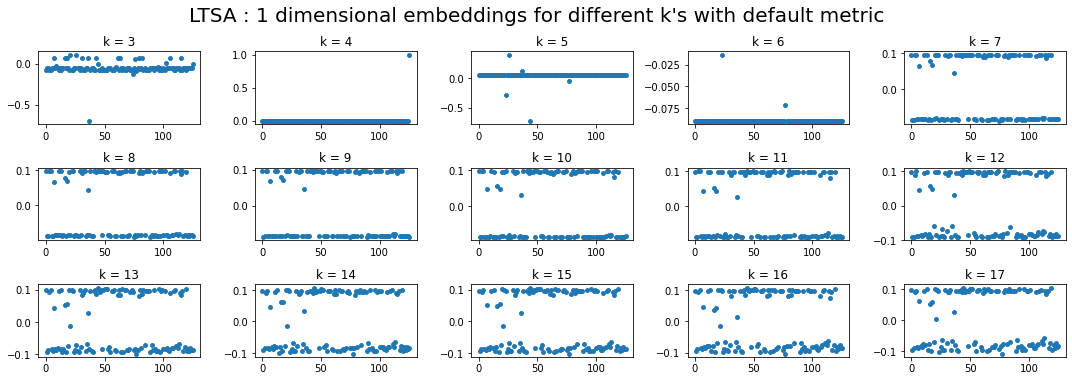

In [29]:
fig, ax = plt.subplots(ncols = 5 , nrows= 3, figsize = (15, 5))
for i in np.arange(15):
    k = i + 3
    ltsa = manifold.LocallyLinearEmbedding(method = "ltsa", n_components= 1, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")
    displacementLTSA = ltsa.fit_transform(displacementFlat)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(np.arange(126), displacementLTSA[:, 0], s = 15)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))
fig.tight_layout()
fig.suptitle("LTSA : 1 dimensional embeddings for different k's with default metric", size = 20, y = 1.05)
plt.show()

We pick one result to analyse further:

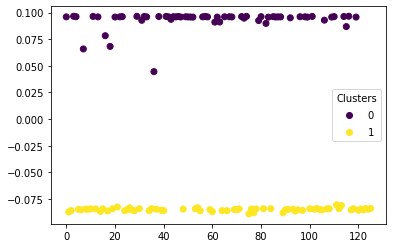

In [30]:
ltsa = manifold.LocallyLinearEmbedding(method = "ltsa", n_components= 1, n_neighbors = 7, eigen_solver = "dense", neighbors_algorithm = "brute")
displacementLTSA = ltsa.fit_transform(displacementFlat)
kmeans =  KMeans(n_clusters= 2 , n_init = 10, tol=1e-4).fit(displacementLTSA)
scatter = plt.scatter(np.arange(126), displacementLTSA[:, 0], c = kmeans.labels_)
legend = plt.legend(*scatter.legend_elements(), title="Clusters", loc = "best")

In [31]:
outliers = np.arange(126)[np.logical_and(displacementLTSA.reshape((126)) < 0.085 , displacementLTSA.reshape((126)) > -0.05)]
groupZero = np.setdiff1d(np.arange(126)[kmeans.labels_ == 0], outliers)
groupOne = np.setdiff1d(np.arange(126)[kmeans.labels_ == 1], outliers)

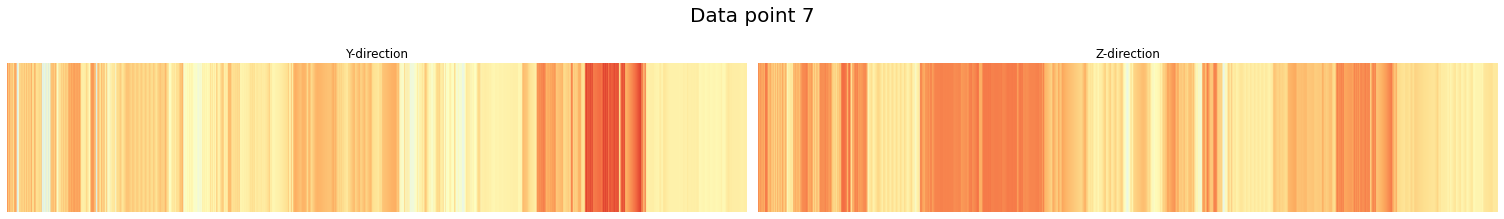

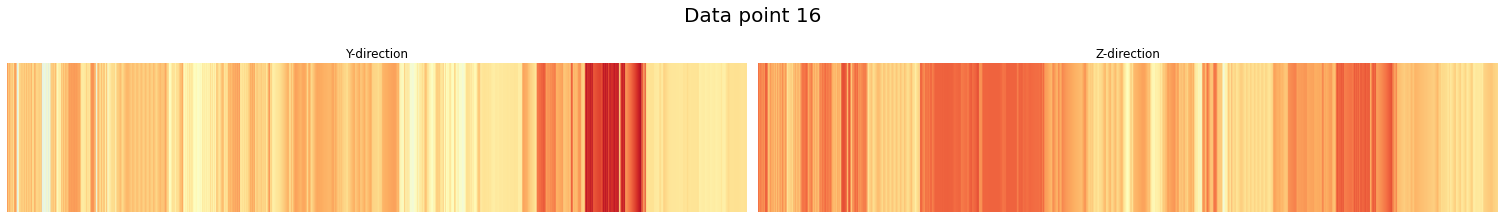

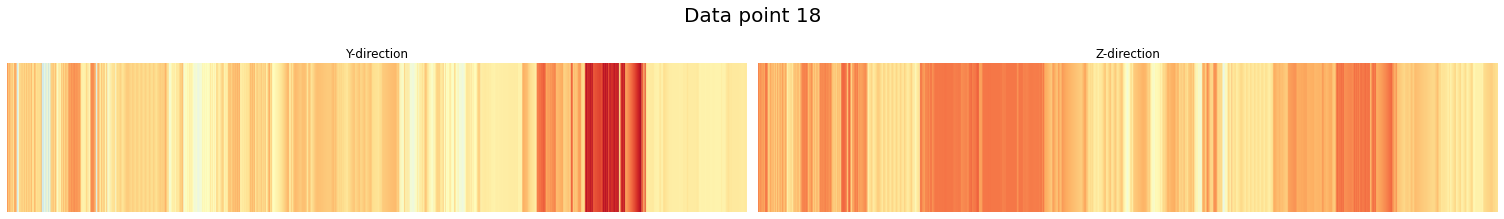

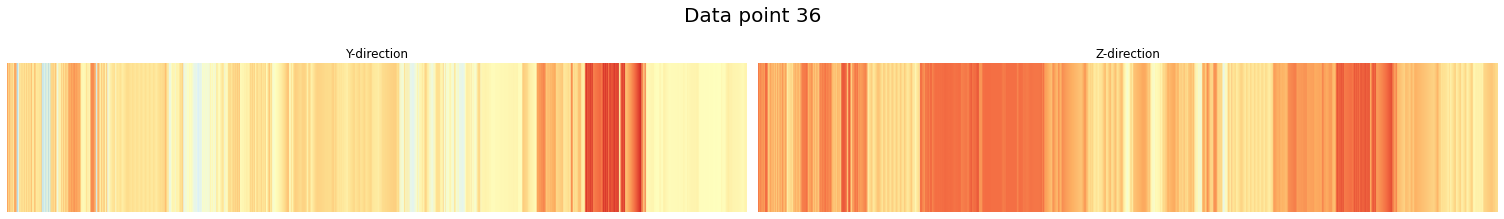

In [32]:
for i in outliers:
    displacementPlot(displacementNorm[i, :, :], showDirection= "yz", title = "Data point " + str(i))

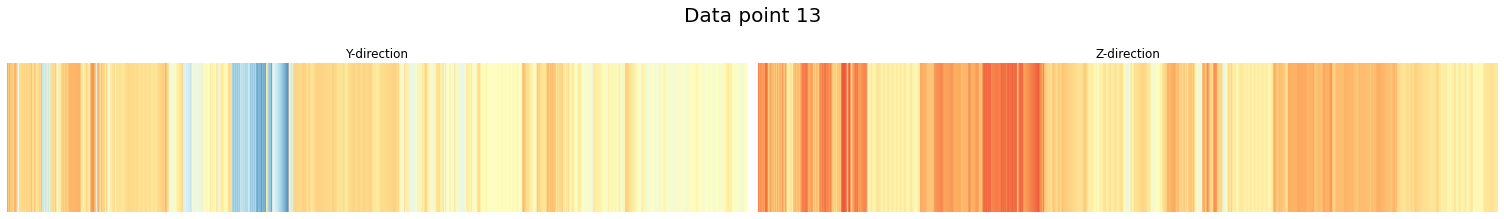

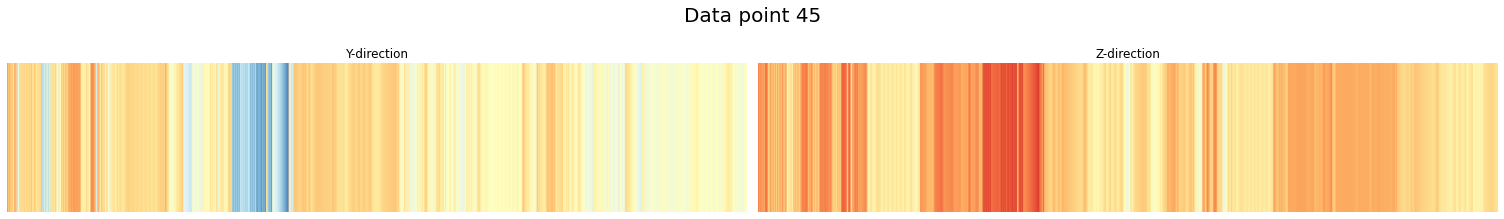

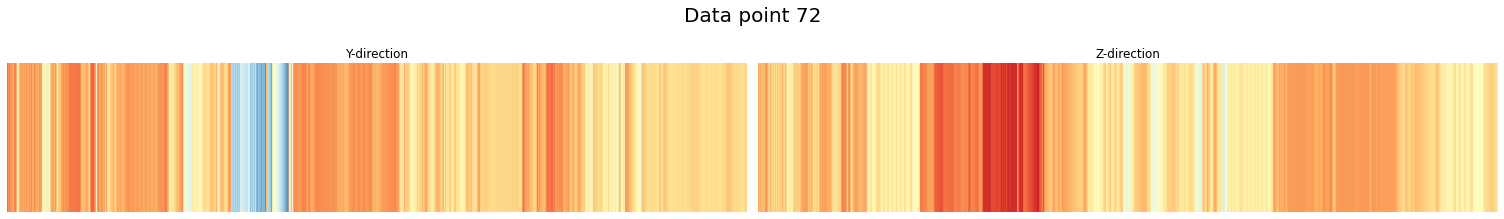

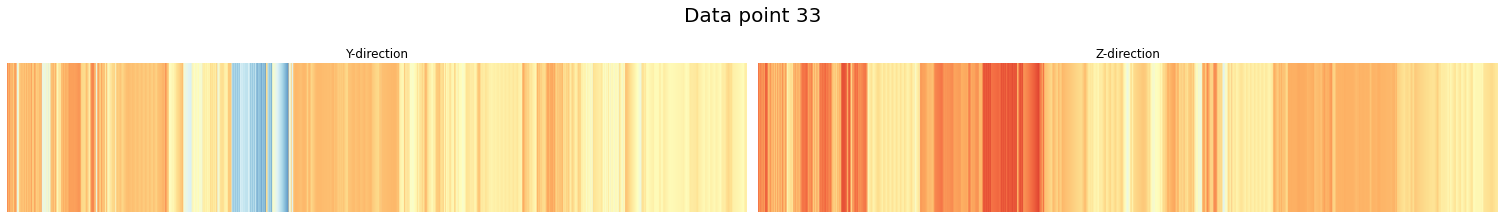

In [33]:
for i in np.random.choice(groupZero, 4):
    displacementPlot(displacementNorm[i, :, :], showDirection= "yz", title = "Data point " + str(i))

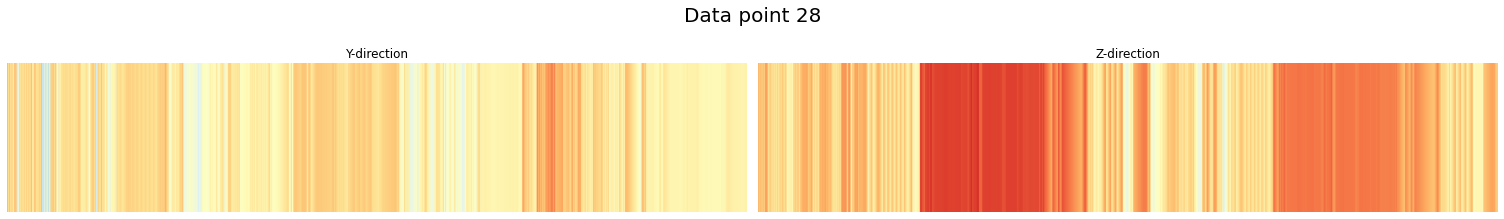

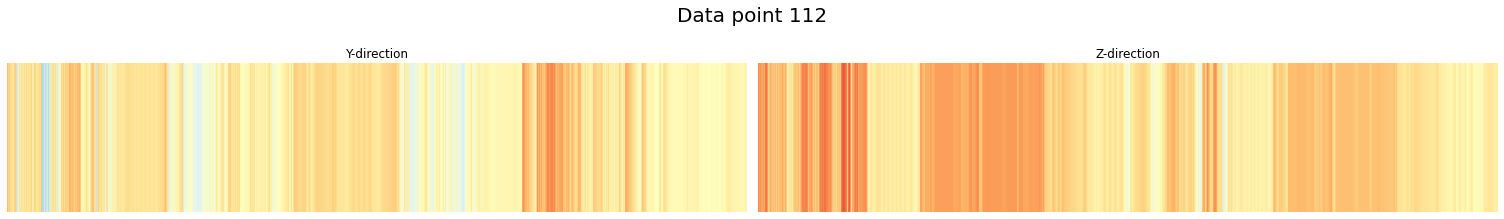

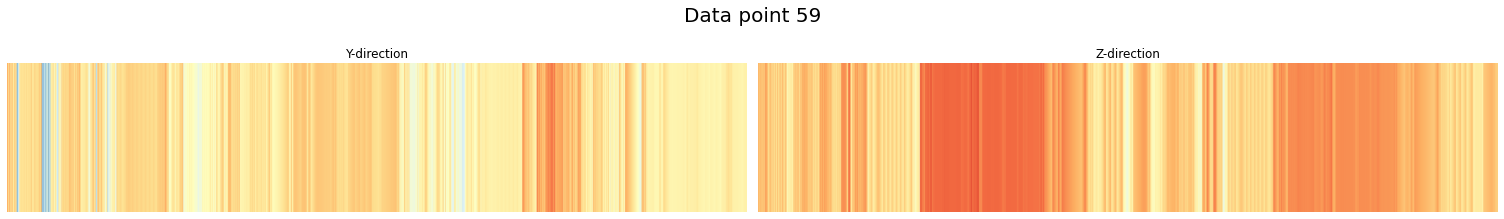

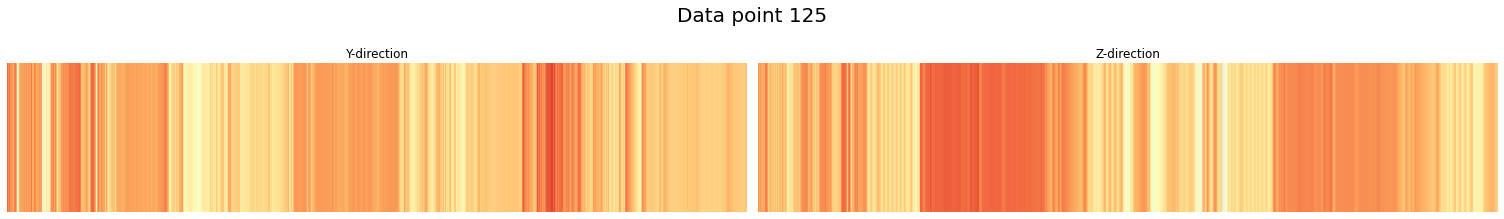

In [34]:
for i in np.random.choice(groupOne, 4):
    displacementPlot(displacementNorm[i, :, :], showDirection= "yz", title = "Data point " + str(i))

We can see that the algorithm was able to divide the set into two groups and also seems to have identified four outliers. 
Let's interpret the meaning of the groups further.

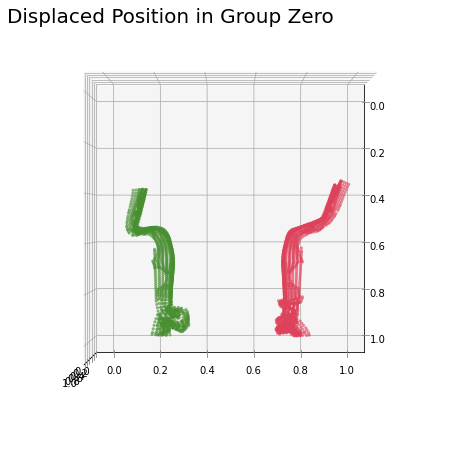

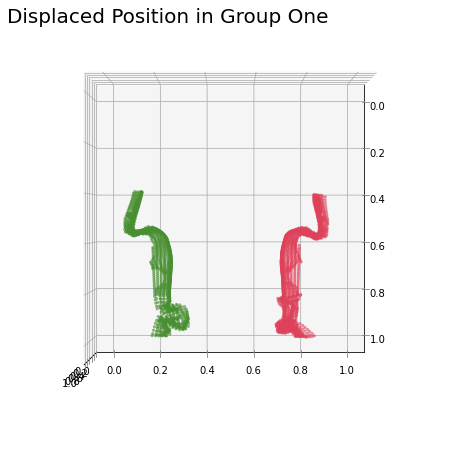

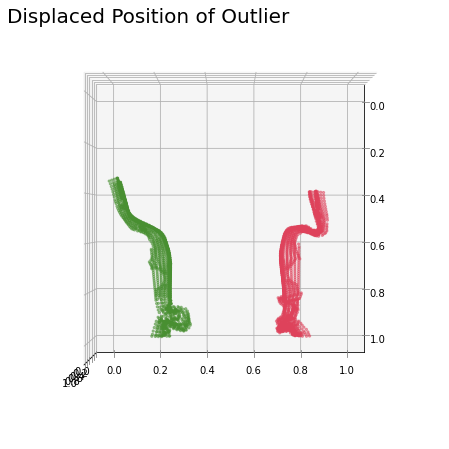

In [35]:
beamPlot(displacedPositionsNorm[110,:,:], 90, 0, "both", title ="Displaced Position in Group Zero")
beamPlot(displacedPositionsNorm[24,:,:], 90, 0, "both", title ="Displaced Position in Group One")
beamPlot(displacedPositionsNorm[16,:,:], 90, 0, "both", title ="Displaced Position of Outlier")


The plots clearly show different behavior!

Let's try using the custom metric:

Since our custom LTSA takes quite some time to run, we have inserted some images. They can be reproduced with the code below.

In [36]:
%run custom_LTSA.ipynb 

In [37]:
# This cell takes around 4 minutes for any value of c
"""
c = 2.5
geodesicDistances = getGeodesicDistances(distanceMatrix, c)
fig, ax = plt.subplots(ncols = 5 , nrows= 2, figsize = (15, 4))
for i in np.arange(10):
    k = i + 4
    ltsa = CustomLocallyLinearEmbedding(method = "ltsa", n_components= 1, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")
    displacementLTSA = ltsa.fit_transform(displacementFlat)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(np.arange(126), displacementLTSA[:, 0], s = 15)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))
fig.tight_layout()
fig.suptitle("LTSA : 1 dimensional embeddings for different k's with custom metric, c =" + str(c), size = 20, y = 1.05)
plt.show()
"""

'\nc = 2.5\ngeodesicDistances = getGeodesicDistances(distanceMatrix, c)\nfig, ax = plt.subplots(ncols = 5 , nrows= 2, figsize = (15, 4))\nfor i in np.arange(10):\n    k = i + 4\n    ltsa = CustomLocallyLinearEmbedding(method = "ltsa", n_components= 1, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")\n    displacementLTSA = ltsa.fit_transform(displacementFlat)\n    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(np.arange(126), displacementLTSA[:, 0], s = 15)\n    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))\nfig.tight_layout()\nfig.suptitle("LTSA : 1 dimensional embeddings for different k\'s with custom metric, c =" + str(c), size = 20, y = 1.05)\nplt.show()\n'

![](Images/LTSA_C=1_1.png)
![](Images/LTSA_C=1_5.png)
![](Images/LTSA_C=2.png)
![](Images/LTSA_C=2_5.png)

We can see that the separation in two groups remains consistent, but that the outlier disappear for smaller values of $c$. 

As expected, the results become more similar to the standard ones as we increase $c$. We don't show the results for even higher values of $c$ since they don't change significantly anymore. The range for $k$ which produces reasonable looking results stays roughly the same. We notice that the results start matching the earlier ones for pretty low values, considering that for $c= 2.5$ only a quarter of the estimated geodesic distances are equal to the euclidean ones. We can infer that the structure of our manifold might be pretty simple. 

Let's investigate one of the results:

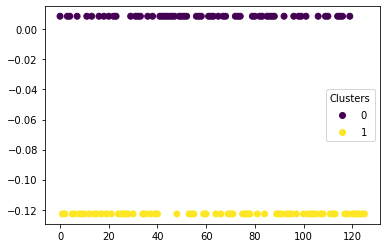

In [51]:
# this cell takes around 20 seconds
c = 2
geodesicDistances = getGeodesicDistances(distanceMatrix, c)
ltsa = CustomLocallyLinearEmbedding(method = "ltsa", n_components= 1, n_neighbors = 7, eigen_solver = "dense", neighbors_algorithm = "brute")
displacementLTSA = ltsa.fit_transform(displacementFlat)
kmeans =  KMeans(n_clusters= 2 , n_init = 10, tol=1e-4).fit(displacementLTSA)
scatter = plt.scatter(np.arange(126), displacementLTSA[:, 0], c = kmeans.labels_)
legend = plt.legend(*scatter.legend_elements(), title="Clusters", loc = "best")

In [39]:
groupZeroCustom = np.arange(126)[kmeans.labels_ == 0]
groupOneCustom = np.arange(126)[kmeans.labels_ == 1]
np.setdiff1d(groupOneCustom, outliers).shape == groupOneCustom.shape

True

In [40]:
np.setdiff1d(groupOne, groupZeroCustom), np.setdiff1d(groupZeroCustom, groupOne), np.setdiff1d(groupZero, groupOneCustom), np.setdiff1d(groupOneCustom, groupZero)


(array([  1,   2,   5,   6,   8,   9,  10,  12,  14,  15,  17,  19,  21,
         24,  25,  26,  27,  28,  30,  34,  35,  37,  39,  40,  48,  53,
         54,  55,  59,  60,  64,  66,  69,  70,  71,  75,  76,  77,  78,
         81,  84,  89,  90,  91,  93,  94,  95,  97, 100, 102, 103, 104,
        105, 107, 108, 111, 112, 113, 117, 118, 120, 121, 122, 123, 124,
        125]),
 array([  0,   3,   4,   7,  11,  13,  16,  18,  20,  22,  23,  29,  31,
         32,  33,  36,  38,  41,  42,  43,  44,  45,  46,  47,  49,  50,
         51,  52,  56,  57,  58,  61,  62,  63,  65,  67,  68,  72,  73,
         74,  79,  80,  82,  83,  85,  86,  87,  88,  92,  96,  98,  99,
        101, 106, 109, 110, 114, 115, 116, 119]),
 array([  0,   3,   4,  11,  13,  20,  22,  23,  29,  31,  32,  33,  38,
         41,  42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  56,  57,
         58,  61,  62,  63,  65,  67,  68,  72,  73,  74,  79,  80,  82,
         83,  85,  86,  87,  88,  92,  96,  98,  99, 101, 1

We can see that the indices of the groups were switched around (which is meaningless) and that the outliers were matched with the new group zero, so the custom LTSA only focused on the behavior of the red beam. 

Since the outliers looked convincing we think that the samples were not dense enough to be well-suited to the custom metric.  That the outlier group identified by the standard LTSA had so few elements also points to that direction. If the sampling is too sparse that the adaptive neighborhood graph might invent wrong contraints. Let's consider the neighborhoods:

In [41]:
print("Outliers", outliers, "neighborhoods:")
for i in outliers:
    print(cNeighborhood(i, distanceMatrix, c= 2))
print("Group 0 avg. neighborhood size:")
sum = 0
for i in groupZero:
    sum += cNeighborhood(i, distanceMatrix, c= 2).shape[0]
print(np.round(sum/groupZero.shape[0], 2))
print("Group 1 avg. neighborhood size:")
sum = 0
for i in groupOne:
    sum += cNeighborhood(i, distanceMatrix, c= 2).shape[0]
print(np.round(sum/groupOne.shape[0], 2))

Outliers [ 7 16 18 36] neighborhoods:
[ 16  18  36 115]
[ 7 18 36]
[ 7 16 36]
[ 7 16 18]
Group 0 avg. neighborhood size:
17.29
Group 1 avg. neighborhood size:
28.41


In [42]:
115 in groupZeroCustom

True

In [43]:
c = 2
geodesicDistances = getGeodesicDistances(distanceMatrix, c)
kNN = NearestNeighbors(n_neighbors=7, algorithm='brute', metric=geodesicDistance).fit(displacementFlat)
for i in outliers:
    neighborsDist, neighbors = kNN.kneighbors(displacementFlat[i, :].reshape((1, 9699)))
    print(i ,":", neighbors)

7 : [[  7  18  36  16 115  82  63]]
16 : [[ 16  18  36   7 115  82  63]]
18 : [[ 18  16   7  36 115  82  63]]
36 : [[ 36  18  16   7 115  82  63]]


In [44]:
82 in groupZeroCustom, 63 in groupZeroCustom

(True, True)

So the only path to the outliers from outside passes through the group they have been assigned to and they lie in an unusually sparse area. Therefore neighborhoods assigned via the estimated geodesic distances contain only group 0 elements. 
Let's compare that to the $k$ nearest neighbors assigned by using the euclidean metric:

In [45]:
kNN = NearestNeighbors(n_neighbors=7, algorithm='brute').fit(displacementFlat)
for i in outliers:
    neighborsDist, neighbors = kNN.kneighbors(displacementFlat[i, :].reshape((1, 9699)))
    print(i ,":", neighbors)

7 : [[  7  18  36  16 115 113 111]]
16 : [[ 16  18  36   7 115  75   2]]
18 : [[ 18  16   7  36 115 113 111]]
36 : [[ 36  18  16   7  90 113   2]]


In [46]:
113 in groupZeroCustom, 111 in groupZeroCustom, 75 in groupZeroCustom, 2 in groupZeroCustom, 90 in groupZeroCustom

(False, False, False, False, False)

We can also see how the situation changes for $c \geq 2.5$:

In [47]:
c = 2.5
geodesicDistances = getGeodesicDistances(distanceMatrix, c)
print("Outliers", outliers, "neighborhoods:")
for i in outliers:
    print(cNeighborhood(i, distanceMatrix, c= c))
print("Group 0 avg. neighborhood size:")
sum = 0
for i in groupZero:
    sum += cNeighborhood(i, distanceMatrix, c= c).shape[0]
print(np.round(sum/groupZero.shape[0], 2))
print("Group 1 avg. neighborhood size:")
sum = 0
for i in groupOne:
    sum += cNeighborhood(i, distanceMatrix, c= c).shape[0]
print(np.round(sum/groupOne.shape[0], 2))

Outliers [ 7 16 18 36] neighborhoods:
[ 10  16  18  36  54  79  90 111 113 115 118 123]
[  7  18  36 115]
[  7  16  36 115]
[  2   5   7  10  16  18  54  75  90 107 111 113 118]
Group 0 avg. neighborhood size:
30.66
Group 1 avg. neighborhood size:
44.06


We can conclude that for small $c$ the adaptive neighborhood graph approach skews the tangent space estimation for the outliers towards the tangent spaces in group 0 .

### Results for s = 2

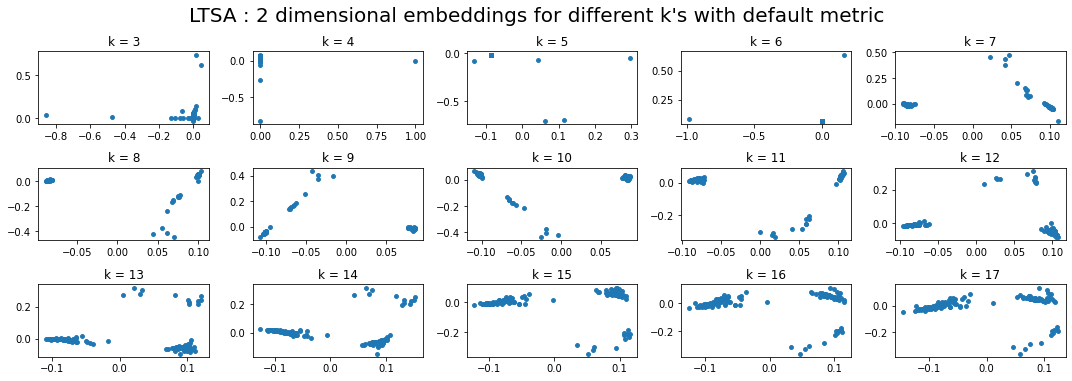

In [48]:
fig, ax = plt.subplots(ncols = 5 , nrows= 3, figsize = (15, 5))
for i in np.arange(15):
    k = i + 3
    ltsa = manifold.LocallyLinearEmbedding(method = "ltsa", n_components= 2, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")
    displacementLTSA = ltsa.fit_transform(displacementFlat)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(displacementLTSA[:, 0], displacementLTSA[:, 1] , s = 15)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))
fig.tight_layout()
fig.suptitle("LTSA : 2 dimensional embeddings for different k's with default metric", size = 20, y = 1.05)
plt.show()

In [49]:
"""
c= 1.05
geodesicDistances = getGeodesicDistances(distanceMatrix, c)
fig, ax = plt.subplots(ncols = 5 , nrows= 2, figsize = (15, 4))
for i in np.arange(10):
    k = i + 4
    ltsa = CustomLocallyLinearEmbedding(method = "ltsa", n_components= 2, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")
    displacementLTSA = ltsa.fit_transform(displacementFlat)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(displacementLTSA[:, 0], displacementLTSA[:, 1] , s = 15)
    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))
fig.tight_layout()
fig.suptitle("LTSA : 2 dimensional embeddings for different k's with custom metric, c =" + str(c), size = 20, y = 1.05)
plt.show()
"""

'\nc= 1.05\ngeodesicDistances = getGeodesicDistances(distanceMatrix, c)\nfig, ax = plt.subplots(ncols = 5 , nrows= 2, figsize = (15, 4))\nfor i in np.arange(10):\n    k = i + 4\n    ltsa = CustomLocallyLinearEmbedding(method = "ltsa", n_components= 2, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")\n    displacementLTSA = ltsa.fit_transform(displacementFlat)\n    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(displacementLTSA[:, 0], displacementLTSA[:, 1] , s = 15)\n    ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))\nfig.tight_layout()\nfig.suptitle("LTSA : 2 dimensional embeddings for different k\'s with custom metric, c =" + str(c), size = 20, y = 1.05)\nplt.show()\n'

![](Images/LTSA_2D_C=1_05.png)
![](Images/LTSA_2D_C=1_1.png)
![](Images/LTSA_2D_C=1_25.png)
![](Images/LTSA_2D_C=1_5.png)
![](Images/LTSA_2D_C=2.png)

The separation obtained by the both methods for $s=2$ is less obvious as for $s=1$ and it's harder to pick a reasonable $k$ or $c$. <br>
The behaviour of the custom LTSA for $c > 2$ stays pretty similar. We won't show all the plots anymore but after looking at a few values of $k, c$ we have come to the following conclusions: 

The standard method shows a third group for higher values of $k$ which is non-uniform (though it contains the earlier outliers) and therefore doesn't seem accurate. For $7 \leq k \leq 10$ the standard method produces similar results as before. 

Some of the custom LTSA results are very off, for example those of $c = 1.5$ but one can also find examples where the clustering is similar to the results of the 1D case. Especially $c = 1.1$ mostly matches the earlier results. There is less of a tendency to split into three groups. This leads us to the conclusion that for $s=2$ the estimated geodesic distances are slightly preferable to the euclidean distances. 

All in all though, it is clear that $s=1$ is a much better choice for our data set. 

### LTSA applied a the node clusters
Lastly, we want see what the dimensionality reduction looks like when we apply it to each node cluster. 

This kind of preprocessing might be of use for more complicated structures with a lot more nodes. Perhaps an engineer could choose clusters which he expects to have the largest impact and then only those get automatically analysed to save time. Since we have not observed an advantage by using our custom metric, we will stick to the standard implementation and $s= 1$.

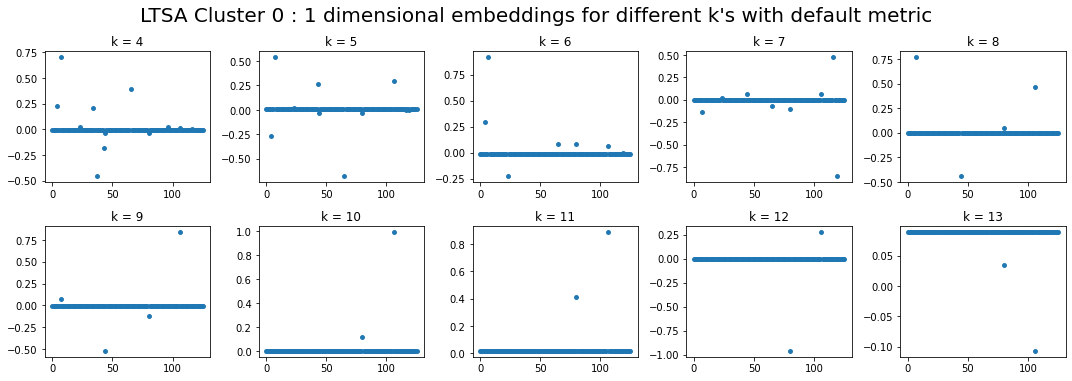

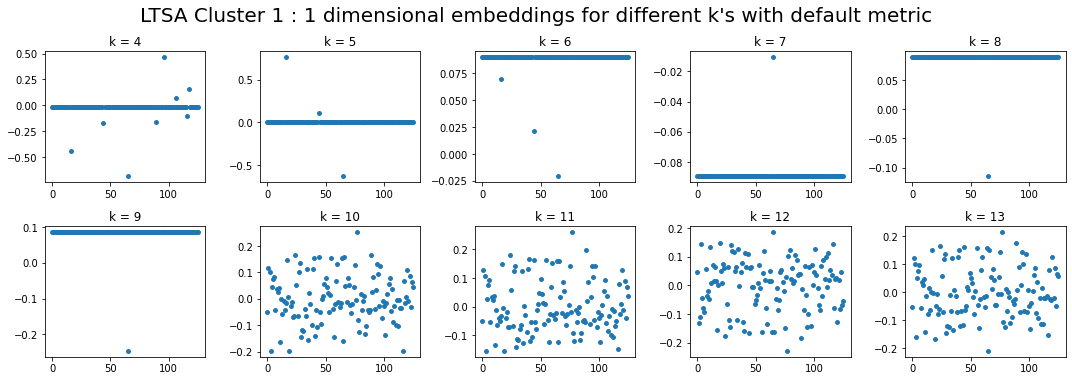

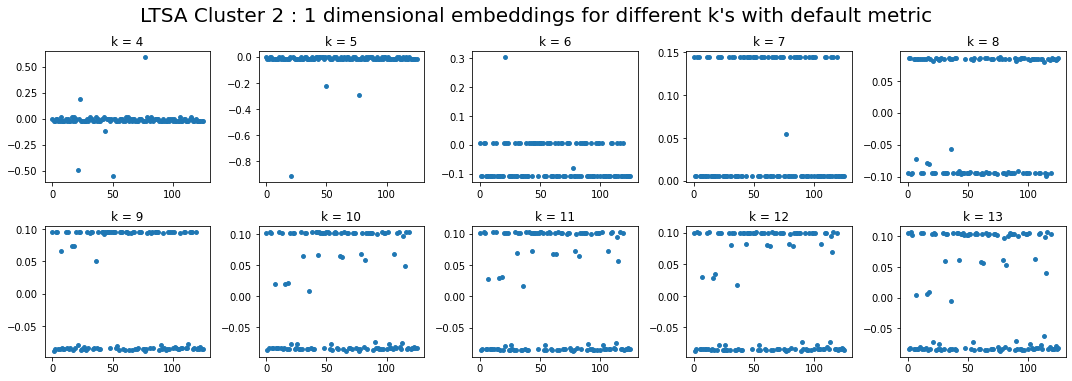

In [50]:
for j in np.arange(3):
    fig, ax = plt.subplots(ncols = 5 , nrows= 2, figsize = (15, 5))
    displacedFlatCluster = displacementSim[:, np.where(kmeansNodes.labels_ == j)[0], :].reshape((N, -1)) 
    for i in np.arange(10):
        k = i + 4
        ltsa = manifold.LocallyLinearEmbedding(method = "ltsa", n_components= 1, n_neighbors = k,  eigen_solver = "dense", neighbors_algorithm = "brute")
        displacementLTSA = ltsa.fit_transform(displacedFlatCluster)
        ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].scatter(np.arange(126), displacementLTSA[:, 0], s = 15)
        ax[int(np.floor(i/5)), int(i - np.floor(i/5) * 5)].set_title("k = " + str(k))
    fig.tight_layout()
    fig.suptitle("LTSA Cluster " + str(j) + " : 1 dimensional embeddings for different k's with default metric", size = 20, y = 1.05)
    plt.show()

As expected, the analysis of cluster consisting of the front part of the beam, which we have observed bending in different directions is able to replicate our earlier results most closely, while the other clusters don't yield any information.

## References

[1] Bastian Bohn, Jochen Garcke, Rodrigo Iza-Teran, Alexander Paprotny, Benjamin Peherstorfer, Ulf Schepsmeier, Clemens-August Thole,
Analysis of Car Crash Simulation Data with Nonlinear Machine Learning Methods,
Procedia Computer Science,
Volume 18,
2013,
Pages 621-630,
ISSN 1877-0509,
https://doi.org/10.1016/j.procs.2013.05.226.
(https://www.sciencedirect.com/science/article/pii/S1877050913003694)

[2] Salvador, Stan & Chan, Philip. (2004). Determining the Number of Clusters/Segments in Hierarchical Clustering/Segmentation Algorithms. Proceedings - International Conference on Tools with Artificial Intelligence, ICTAI. 576- 584. 10.1109/ICTAI.2004.50. 

[3] Z. Zhang, H. Zha, Principal manifolds and nonlinear dimension reduction via local tangent space alignment, SIAM SISC 26 (1) (2004)
313–338.

[4] J. Giesen, U. Wagner, Shape dimension and intrinsic metric from samples of manifolds with high co-dimension, Proc. 19th Annual
ACM Symposium on Computational Geometry (SoCG), 2003, pp. 329–337.

